# "Bivariate" BMM for n = 3, ..., N models

### Author: Alexandra Semposki

### Date: 11 October 2022

Unlike the last notebook, Bivariate_Test, this one focusses on the N model case for this SAMBA mixing technique. Hence, it is no longer truly bivariate, but multivariate. This will only mix the models together in the Gaussian format without employing any GPs (yet). 

In [1]:
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.ticker import AutoMinorLocator

matplotlib.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
})

We import the models we'll need from the package SAMBA (wrapped with Taweret) and import the Multivariate mixer from the `gaussian.py` file.

In [2]:
import sys
sys.path.append('../../../../Taweret')
sys.path.append('../../../../SAMBA')
from Taweret.models.samba_models import *
from Taweret.mix.gaussian import *

No module named 'samba'
To use the SAMBA toy models, SAMBA package needed to be installed first
Then use `sys.path.append("path_to_local_SAMBA_instalation")` in your code before calling SAMBA models


We pick the truncation orders we would like to investigate in our model mixing, and select which model will be using which truncation order. We're considering a toy model, which can be expanded in powers of a coupling constant $g$ or in $1/g$. This means that we need two different series: `loworder` represents the series expansion at small-$g$, and `highorder` the series expansion at large-$g$. 

In [3]:
#list of models to mix
orders=[3,5,7]
model_1 = loworder(order=orders[0])
model_2 = loworder(order=orders[1])
model_3 = highorder(order=orders[2])

Now we compile these models into a dictionary that we can pass into Taweret.

In [4]:
#dict of models
models = {
    "1": model_1,
    "2": model_2,
    "3": model_3
}

print(models, type(models))

{'1': <Taweret.models.samba_models.loworder object at 0x000001F88EBC1580>, '2': <Taweret.models.samba_models.loworder object at 0x000001F88EBC15E0>, '3': <Taweret.models.samba_models.highorder object at 0x000001F88EBC15B0>} <class 'dict'>


Now we would like to see the models we just saved, so we evaluate them at the input points we choose and plot each model individually, along with its 68\% uncertainties.

In [5]:
#predict functions for the plot
g = np.linspace(1e-6, 1.0, 100)
predict = []

for i in models.keys():
    predict.append(models[i].evaluate(g))

Now let's plot!

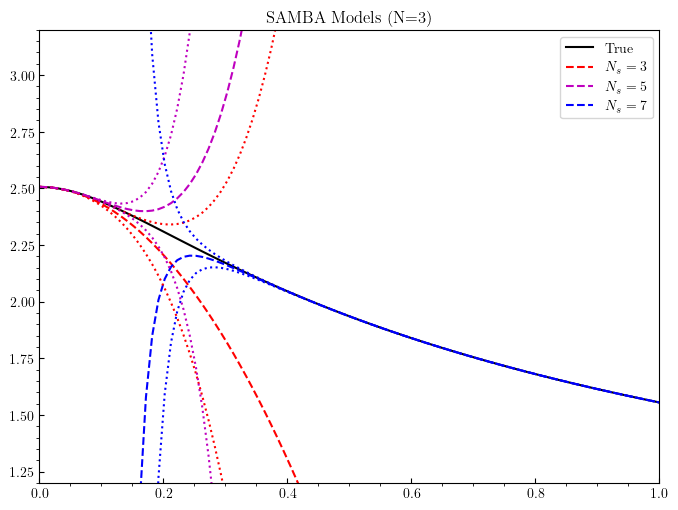

In [6]:
#basic plot to check choices
fig = plt.figure(figsize=(8,6), dpi=100)
ax = plt.axes()
ax.set_xlim(0.0,1.0)
ax.set_ylim(1.2,3.2)
ax.tick_params(axis='x', direction='in')
ax.tick_params(axis='y', direction='in')
ax.locator_params(nbins=8)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_title('SAMBA Models (N=3)')

#truth
ax.plot(g, true_model().evaluate(g)[0].flatten(), 'k', label='True')

#colour wheel
colors = ['r', 'm', 'b']
lines = ['dashed', 'dotted']

#models
for i in range(len(predict)):
    ax.plot(g, predict[i][0].flatten(), color=colors[i], linestyle=lines[0], label=r'$N_s={}$'.format(orders[i]))

#uncertainties
for i in range(len(predict)):
    ax.plot(g, predict[i][0].flatten() - predict[i][1].flatten(), color=colors[i], linestyle=lines[1])
    ax.plot(g, predict[i][0].flatten() + predict[i][1].flatten(), color=colors[i], linestyle=lines[1])

ax.legend()

Now we would like to mix. We call the Multivariate() class from Taweret and send it the input space and the models we created, instantiate an object, and then use the `predict` method in the Multivariate() class to mix the models and send back the mean, intervals, and standard deviation of the mixed model. 

In [7]:
#call bivariate method and mix
mixed = Multivariate(g, models)
posterior_draws, mixed_mean, mixed_intervals, std_dev = mixed.predict()

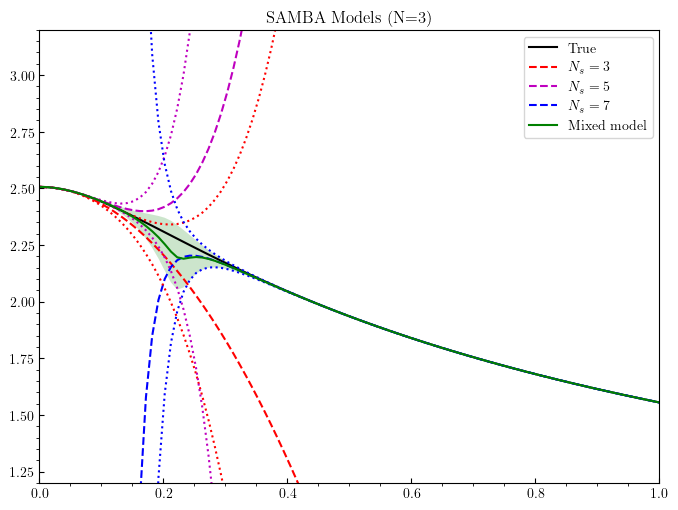

In [8]:
#plot to check mixed model
fig = plt.figure(figsize=(8,6), dpi=100)
ax = plt.axes()
ax.set_xlim(0.0,1.0)
ax.set_ylim(1.2,3.2)
ax.tick_params(axis='x', direction='in')
ax.tick_params(axis='y', direction='in')
ax.locator_params(nbins=8)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_title('SAMBA Models (N=3)')

#truth
ax.plot(g, true_model().evaluate(g)[0].flatten(), 'k', label='True')

#colour wheel
colors = ['r', 'm', 'b']
lines = ['dashed', 'dotted']

#models
for i in range(len(predict)):
    ax.plot(g, predict[i][0].flatten(), color=colors[i], linestyle=lines[0], label=r'$N_s={}$'.format(orders[i]))

#uncertainties
for i in range(len(predict)):
    ax.plot(g, predict[i][0].flatten() - predict[i][1].flatten(), color=colors[i], linestyle=lines[1])
    ax.plot(g, predict[i][0].flatten() + predict[i][1].flatten(), color=colors[i], linestyle=lines[1])

#mean and intervals
ax.plot(g, mixed_mean, 'g', label='Mixed model')
ax.fill_between(g, mixed_mean-std_dev, mixed_mean+std_dev,
                        zorder=i-5, facecolor='green', alpha=0.2, lw=0.6)

ax.legend()

Excellent! We have a mixed model for these three individual series expansions. Now we can add a GP as the third model (or more) if we desire. In Taweret, the user has all control over the models that they write to input. Hence, one can design any model one wishes to use, as long as it possesses the ability to produce a mean and a set of uncertainties at each point in the input space.